In [ ]:
!pip install -q -U torch=="2.4.0" bitsandbytes datasets transformers accelerate wandb trl peft evaluate rouge_score

# Setup Initialization

In [1]:
import os
import wandb
import torch
import bitsandbytes as bnb
import pandas as pd
import numpy as np
import warnings
from datasets import load_dataset
from functools import partial
from transformers import (
    BitsAndBytesConfig, 
    AutoModelForCausalLM, 
    AutoTokenizer, 
    TrainingArguments
)
from peft import (
    LoraConfig, 
    prepare_model_for_kbit_training, 
    get_peft_model, 
    PeftModel
)
from trl import SFTTrainer
import evaluate

import warnings
warnings.filterwarnings('ignore')

In [2]:
os.environ["WANDB_PROJECT"] = 'llm-finetuning-for-summarisation'
os.environ["WANDB_LOG_MODEL"] = 'end'
os.environ["WANDB_WATCH"] = 'false'

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["TOKENIZERS_PARALLELISM"] = 'false'

In [3]:
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: varundixit4. Use `wandb login --relogin` to force relogin


True

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"working on {device}")

working on cuda:0


In [5]:
torch.backends.cuda.enable_mem_efficient_sdp(False)
torch.backends.cuda.enable_flash_sdp(False)

# Load Dataset

In [6]:
huggingface_dataset = 'neil-code/dialogsum-test'
dataset = load_dataset(huggingface_dataset)

In [7]:
dataset['train'][0]

{'id': 'train_0',
 'dialogue': "#Person1#: Hi, Mr. Smith. I'm Doctor Hawkins. Why are you here today?\n#Person2#: I found it would be a good idea to get a check-up.\n#Person1#: Yes, well, you haven't had one for 5 years. You should have one every year.\n#Person2#: I know. I figure as long as there is nothing wrong, why go see the doctor?\n#Person1#: Well, the best way to avoid serious illnesses is to find out about them early. So try to come at least once a year for your own good.\n#Person2#: Ok.\n#Person1#: Let me see here. Your eyes and ears look fine. Take a deep breath, please. Do you smoke, Mr. Smith?\n#Person2#: Yes.\n#Person1#: Smoking is the leading cause of lung cancer and heart disease, you know. You really should quit.\n#Person2#: I've tried hundreds of times, but I just can't seem to kick the habit.\n#Person1#: Well, we have classes and some medications that might help. I'll give you more information before you leave.\n#Person2#: Ok, thanks doctor.",
 'summary': "Mr. Smith'

# QLORA Setup

In [8]:
compute_dtype = getattr(torch, "float16")
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=False,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=compute_dtype,
)

# Load Model

In [9]:
model_name = "NousResearch/Llama-3.2-1B"

original_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map=device,
    torch_dtype=compute_dtype,
    quantization_config=bnb_config, 
)

original_model.config.use_cache = False
original_model.config.pretraining_tp = 1

# Load Tokenizer

In [10]:
max_seq_length = 512
tokenizer = AutoTokenizer.from_pretrained(model_name, max_seq_length=max_seq_length, padding_side="left",add_eos_token=True,add_bos_token=True,use_fast=False)
tokenizer.pad_token_id = tokenizer.eos_token_id

# Function to Generate LLM Response

In [11]:
def generate(model, prompt, max_length, tokenizer):
    inputs = tokenizer(
        prompt,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=512
    ).to(model.device)

    outputs = model.generate(
        inputs.input_ids,
        attention_mask=inputs.attention_mask,
        max_new_tokens=max_length,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.pad_token_id,
        num_beams=5,
        temperature=0.1,
        top_p=0.9,
        repetition_penalty=1.2
    )
    return tokenizer.batch_decode(outputs, skip_special_tokens=True)

# Zero-Shot Response

In [12]:
%%time
from transformers import set_seed
seed = 47
set_seed(seed)

index = 10

prompt = dataset['test'][index]['dialogue']
summary = dataset['test'][index]['summary']

formatted_prompt = f"Instruct: Summarize the following conversation.\n{prompt}\nOutput:\n"
res = generate(original_model,formatted_prompt,100,tokenizer)
output = res[0].split('Output:\n')[1]

dash_line = '-'.join('' for x in range(100))
print(dash_line)
print(f'INPUT PROMPT:\n{formatted_prompt}')
print(dash_line)
print(f'BASELINE HUMAN SUMMARY:\n{summary}\n')
print(dash_line)
print(f'MODEL GENERATION - ZERO SHOT:\n{output}')
print(dash_line)

---------------------------------------------------------------------------------------------------
INPUT PROMPT:
Instruct: Summarize the following conversation.
#Person1#: Happy Birthday, this is for you, Brian.
#Person2#: I'm so happy you remember, please come in and enjoy the party. Everyone's here, I'm sure you have a good time.
#Person1#: Brian, may I have a pleasure to have a dance with you?
#Person2#: Ok.
#Person1#: This is really wonderful party.
#Person2#: Yes, you are always popular with everyone. and you look very pretty today.
#Person1#: Thanks, that's very kind of you to say. I hope my necklace goes with my dress, and they both make me look good I feel.
#Person2#: You look great, you are absolutely glowing.
#Person1#: Thanks, this is a fine party. We should have a drink together to celebrate your birthday
Output:

---------------------------------------------------------------------------------------------------
BASELINE HUMAN SUMMARY:
#Person1# attends Brian's birthday pa

# Functions to Process Dataset for Fine-Tuning

In [13]:
def create_prompt_formats(sample):
    """
    Format various fields of the sample ('instruction','output')
    Then concatenate them using two newline characters 
    :param sample: Sample dictionnary
    """
    INTRO_BLURB = "Below is an instruction that describes a task. Write a response that appropriately completes the request."
    INSTRUCTION_KEY = "### Instruct: Summarize the below conversation."
    RESPONSE_KEY = "### Output:"
    END_KEY = "### End"
    
    blurb = f"\n{INTRO_BLURB}"
    instruction = f"{INSTRUCTION_KEY}"
    input_context = f"{sample['dialogue']}" if sample["dialogue"] else None
    response = f"{RESPONSE_KEY}\n{sample['summary']}"
    end = f"{END_KEY}"
    
    parts = [part for part in [blurb, instruction, input_context, response, end] if part]

    formatted_prompt = "\n\n".join(parts)
    sample["text"] = formatted_prompt

    return sample

In [14]:
def get_max_length(model):
    conf = model.config
    max_length = None
    for length_setting in ["n_positions", "max_position_embeddings", "seq_length"]:
        max_length = getattr(model.config, length_setting, None)
        if max_length:
            print(f"Found max lenth: {max_length}")
            break
    if not max_length:
        max_length = 1024
        print(f"Using default max length: {max_length}")
    return max_length

In [15]:
def preprocess_batch(batch, tokenizer, max_length):
    """
    Tokenizing a batch
    """
    return tokenizer(
        batch["text"],
        max_length=max_length,
        truncation=True,
    )

In [16]:
def preprocess_dataset(tokenizer: AutoTokenizer, max_length: int,seed, dataset):
    """Format & tokenize it so it is ready for training
    :param tokenizer (AutoTokenizer): Model Tokenizer
    :param max_length (int): Maximum number of tokens to emit from tokenizer
    """
    
    print("Preprocessing dataset...")
    dataset = dataset.map(create_prompt_formats)
    
    _preprocessing_function = partial(preprocess_batch, max_length=max_length, tokenizer=tokenizer)
    dataset = dataset.map(
        _preprocessing_function,
        batched=True,
        remove_columns=['id', 'topic', 'dialogue', 'summary'],
    )

    dataset = dataset.filter(lambda sample: len(sample["input_ids"]) < max_length)
    dataset = dataset.shuffle(seed=seed)

    return dataset

# Preprocess Dataset

In [17]:
max_length = get_max_length(original_model)
print(max_length)

train_dataset = preprocess_dataset(tokenizer, max_length,seed, dataset['train'])

Found max lenth: 131072
131072
Preprocessing dataset...


# Setup PEFT Config

In [18]:
original_model = prepare_model_for_kbit_training(original_model)
original_model.gradient_checkpointing_enable()

In [19]:
output_dir="trained_weights"

peft_config = LoraConfig(
    lora_alpha=16,
    lora_dropout=0,
    r=64,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj",
                    "gate_proj", "up_proj", "down_proj",],
)

peft_model = get_peft_model(original_model, peft_config)

# Setup SFTTrainer

In [20]:
training_arguments = TrainingArguments(
    output_dir=output_dir,
    per_device_train_batch_size=1,
    gradient_accumulation_steps=8,
    gradient_checkpointing=True,
    optim="paged_adamw_32bit",
    save_steps=100,
    logging_steps=25, 
    learning_rate=2e-4,
    weight_decay=0.001,
    fp16=True,
    bf16=False,
    max_grad_norm=0.3,
    max_steps=1000,
    warmup_ratio=0.03,
    group_by_length=False,
    lr_scheduler_type="cosine",
    report_to="wandb",
)

trainer = SFTTrainer(
    model=peft_model,
    args=training_arguments,
    train_dataset=train_dataset,
    peft_config=peft_config,
    dataset_text_field="text",
    tokenizer=tokenizer,
    max_seq_length=max_seq_length,
    packing=False,
    dataset_kwargs={
        "add_special_tokens": False,
        "append_concat_token": False,
    },
)

max_steps is given, it will override any value given in num_train_epochs


# Train the Model

In [21]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Step,Training Loss
25,2.014700
50,1.614300
75,1.573300
100,1.501100
125,1.531200
150,1.525300
175,1.496200
200,1.478400
225,1.517300
250,1.495500


max_steps is given, it will override any value given in num_train_epochs


TrainOutput(global_step=1000, training_loss=1.3504333724975586, metrics={'train_runtime': 3910.457, 'train_samples_per_second': 2.046, 'train_steps_per_second': 0.256, 'total_flos': 1.28258494660608e+16, 'train_loss': 1.3504333724975586, 'epoch': 4.00200100050025})

# Inference of Trained Model

In [22]:
base_model = AutoModelForCausalLM.from_pretrained(model_name, 
                                                device_map=device,
                                                torch_dtype=compute_dtype,
                                                quantization_config=bnb_config,)

In [23]:
eval_tokenizer = AutoTokenizer.from_pretrained(model_name, add_bos_token=True, trust_remote_code=True, use_fast=False)
eval_tokenizer.pad_token = eval_tokenizer.eos_token

In [24]:
ft_model = PeftModel.from_pretrained(base_model, "/kaggle/working/trained_weights/checkpoint-900", torch_dtype=torch.float16, is_trainable=False)

In [26]:
%%time
from transformers import set_seed
set_seed(seed)

index = 10
dialogue = dataset['test'][index]['dialogue']
summary = dataset['test'][index]['summary']

prompt = f"Instruct: Summarize the following conversation.\n{dialogue}\nOutput:\n"

peft_model_res = generate(ft_model,prompt,100,eval_tokenizer)
peft_model_output = peft_model_res[0].split('Output:\n')[1]
prefix, success, result = peft_model_output.partition('###')

dash_line = '-'.join('' for x in range(100))
print(dash_line)
print(f'INPUT PROMPT:\n{prompt}')
print(dash_line)
print(f'BASELINE HUMAN SUMMARY:\n{summary}\n')
print(dash_line)
print(f'PEFT MODEL:\n{prefix}')

---------------------------------------------------------------------------------------------------
INPUT PROMPT:
Instruct: Summarize the following conversation.
#Person1#: Happy Birthday, this is for you, Brian.
#Person2#: I'm so happy you remember, please come in and enjoy the party. Everyone's here, I'm sure you have a good time.
#Person1#: Brian, may I have a pleasure to have a dance with you?
#Person2#: Ok.
#Person1#: This is really wonderful party.
#Person2#: Yes, you are always popular with everyone. and you look very pretty today.
#Person1#: Thanks, that's very kind of you to say. I hope my necklace goes with my dress, and they both make me look good I feel.
#Person2#: You look great, you are absolutely glowing.
#Person1#: Thanks, this is a fine party. We should have a drink together to celebrate your birthday
Output:

---------------------------------------------------------------------------------------------------
BASELINE HUMAN SUMMARY:
#Person1# attends Brian's birthday pa

# Evaluation using ROGUE Score

In [28]:
original_model = AutoModelForCausalLM.from_pretrained(model_name, 
                                                      device_map=device,
                                                      torch_dtype=compute_dtype,
                                                      quantization_config=bnb_config,)

In [29]:
dialogues = dataset['test'][0:10]['dialogue']
human_baseline_summaries = dataset['test'][0:10]['summary']

original_model_summaries = []
peft_model_summaries = []

for idx, dialogue in enumerate(dialogues):
    human_baseline_text_output = human_baseline_summaries[idx]
    prompt = f"Instruct: Summarize the following conversation.\n{dialogue}\nOutput:\n"
    
    original_model_res = generate(original_model,prompt,100,eval_tokenizer)
    original_model_text_output = original_model_res[0].split('Output:\n')[1]
    
    peft_model_res = generate(ft_model,prompt,100,eval_tokenizer)
    peft_model_output = peft_model_res[0].split('Output:\n')[1]
    peft_model_text_output, success, result = peft_model_output.partition('###')

    original_model_summaries.append(original_model_text_output)
    peft_model_summaries.append(peft_model_text_output)

zipped_summaries = list(zip(human_baseline_summaries, original_model_summaries, peft_model_summaries))
 
df = pd.DataFrame(zipped_summaries, columns = ['human_baseline_summaries', 'original_model_summaries', 'peft_model_summaries'])

In [32]:
rouge = evaluate.load('rouge')

original_model_results = rouge.compute(
    predictions=original_model_summaries,
    references=human_baseline_summaries[0:len(original_model_summaries)],
    use_aggregator=True,
    use_stemmer=True,
)

peft_model_results = rouge.compute(
    predictions=peft_model_summaries,
    references=human_baseline_summaries[0:len(peft_model_summaries)],
    use_aggregator=True,
    use_stemmer=True,
)

print('ORIGINAL MODEL:')
print(original_model_results)
print('PEFT MODEL:')
print(peft_model_results)

print("Absolute percentage improvement of PEFT MODEL over ORIGINAL MODEL")

improvement = (np.array(list(peft_model_results.values())) - np.array(list(original_model_results.values())))
for key, value in zip(peft_model_results.keys(), improvement):
    print(f'{key}: {value*100:.2f}%')

ORIGINAL MODEL:
{'rouge1': 0.2895314607826919, 'rouge2': 0.09058111562913862, 'rougeL': 0.20996585282618457, 'rougeLsum': 0.2361721138974836}
PEFT MODEL:
{'rouge1': 0.3991549292971125, 'rouge2': 0.17345543539466668, 'rougeL': 0.32448061117271254, 'rougeLsum': 0.3246752770803319}
Absolute percentage improvement of PEFT MODEL over ORIGINAL MODEL
rouge1: 10.96%
rouge2: 8.29%
rougeL: 11.45%
rougeLsum: 8.85%


# Runs Dashboard from WandB

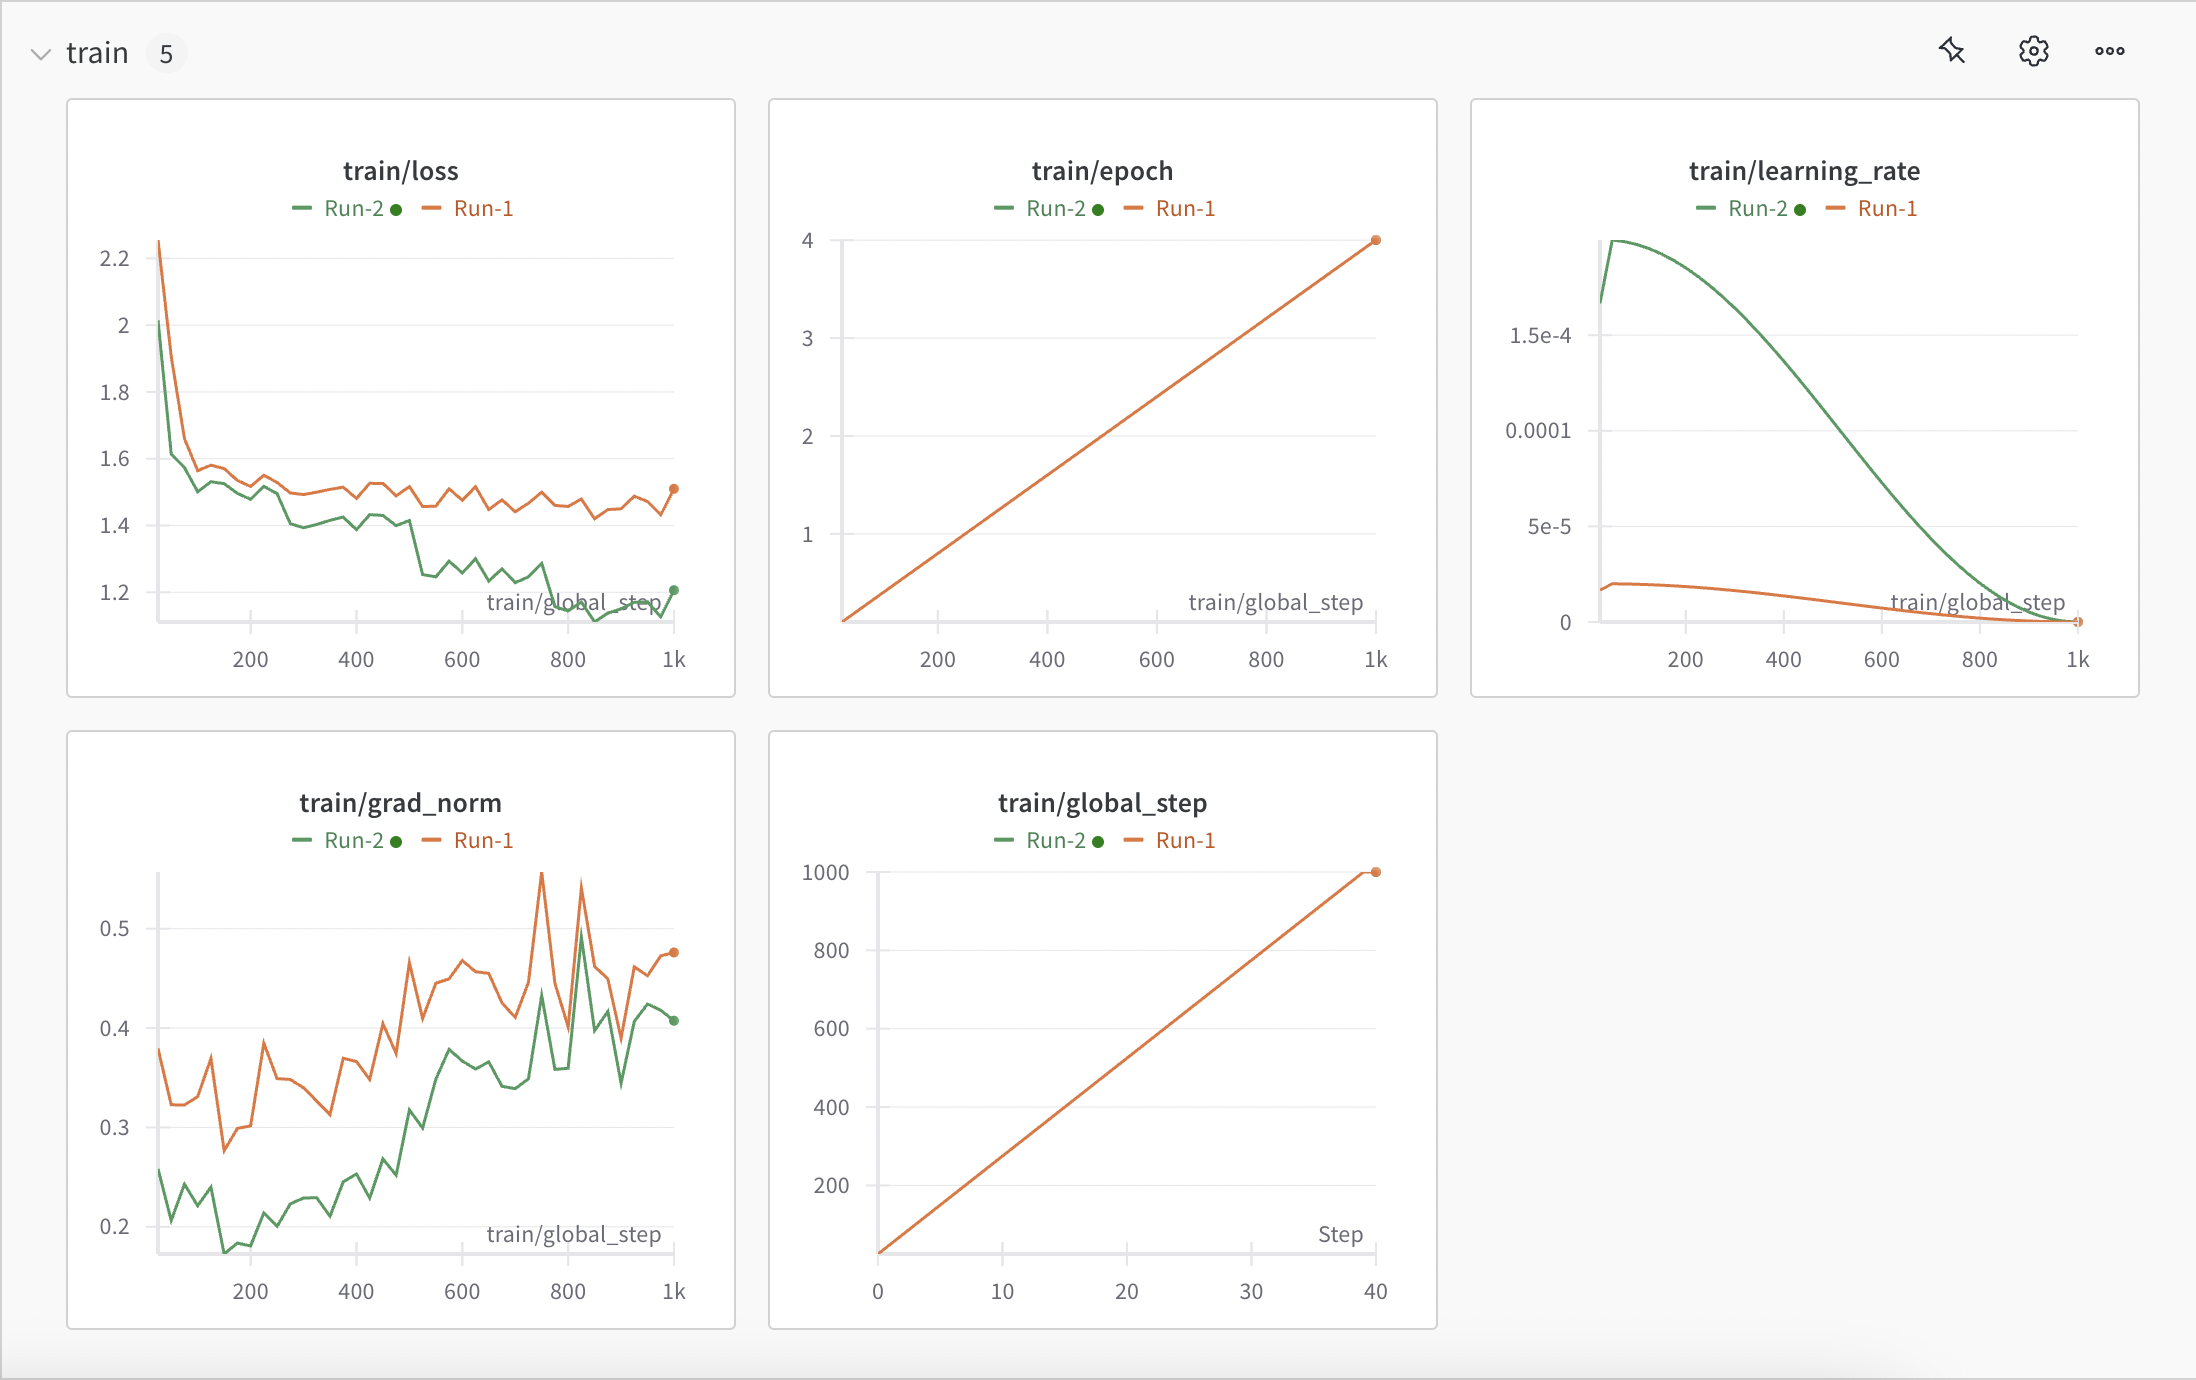
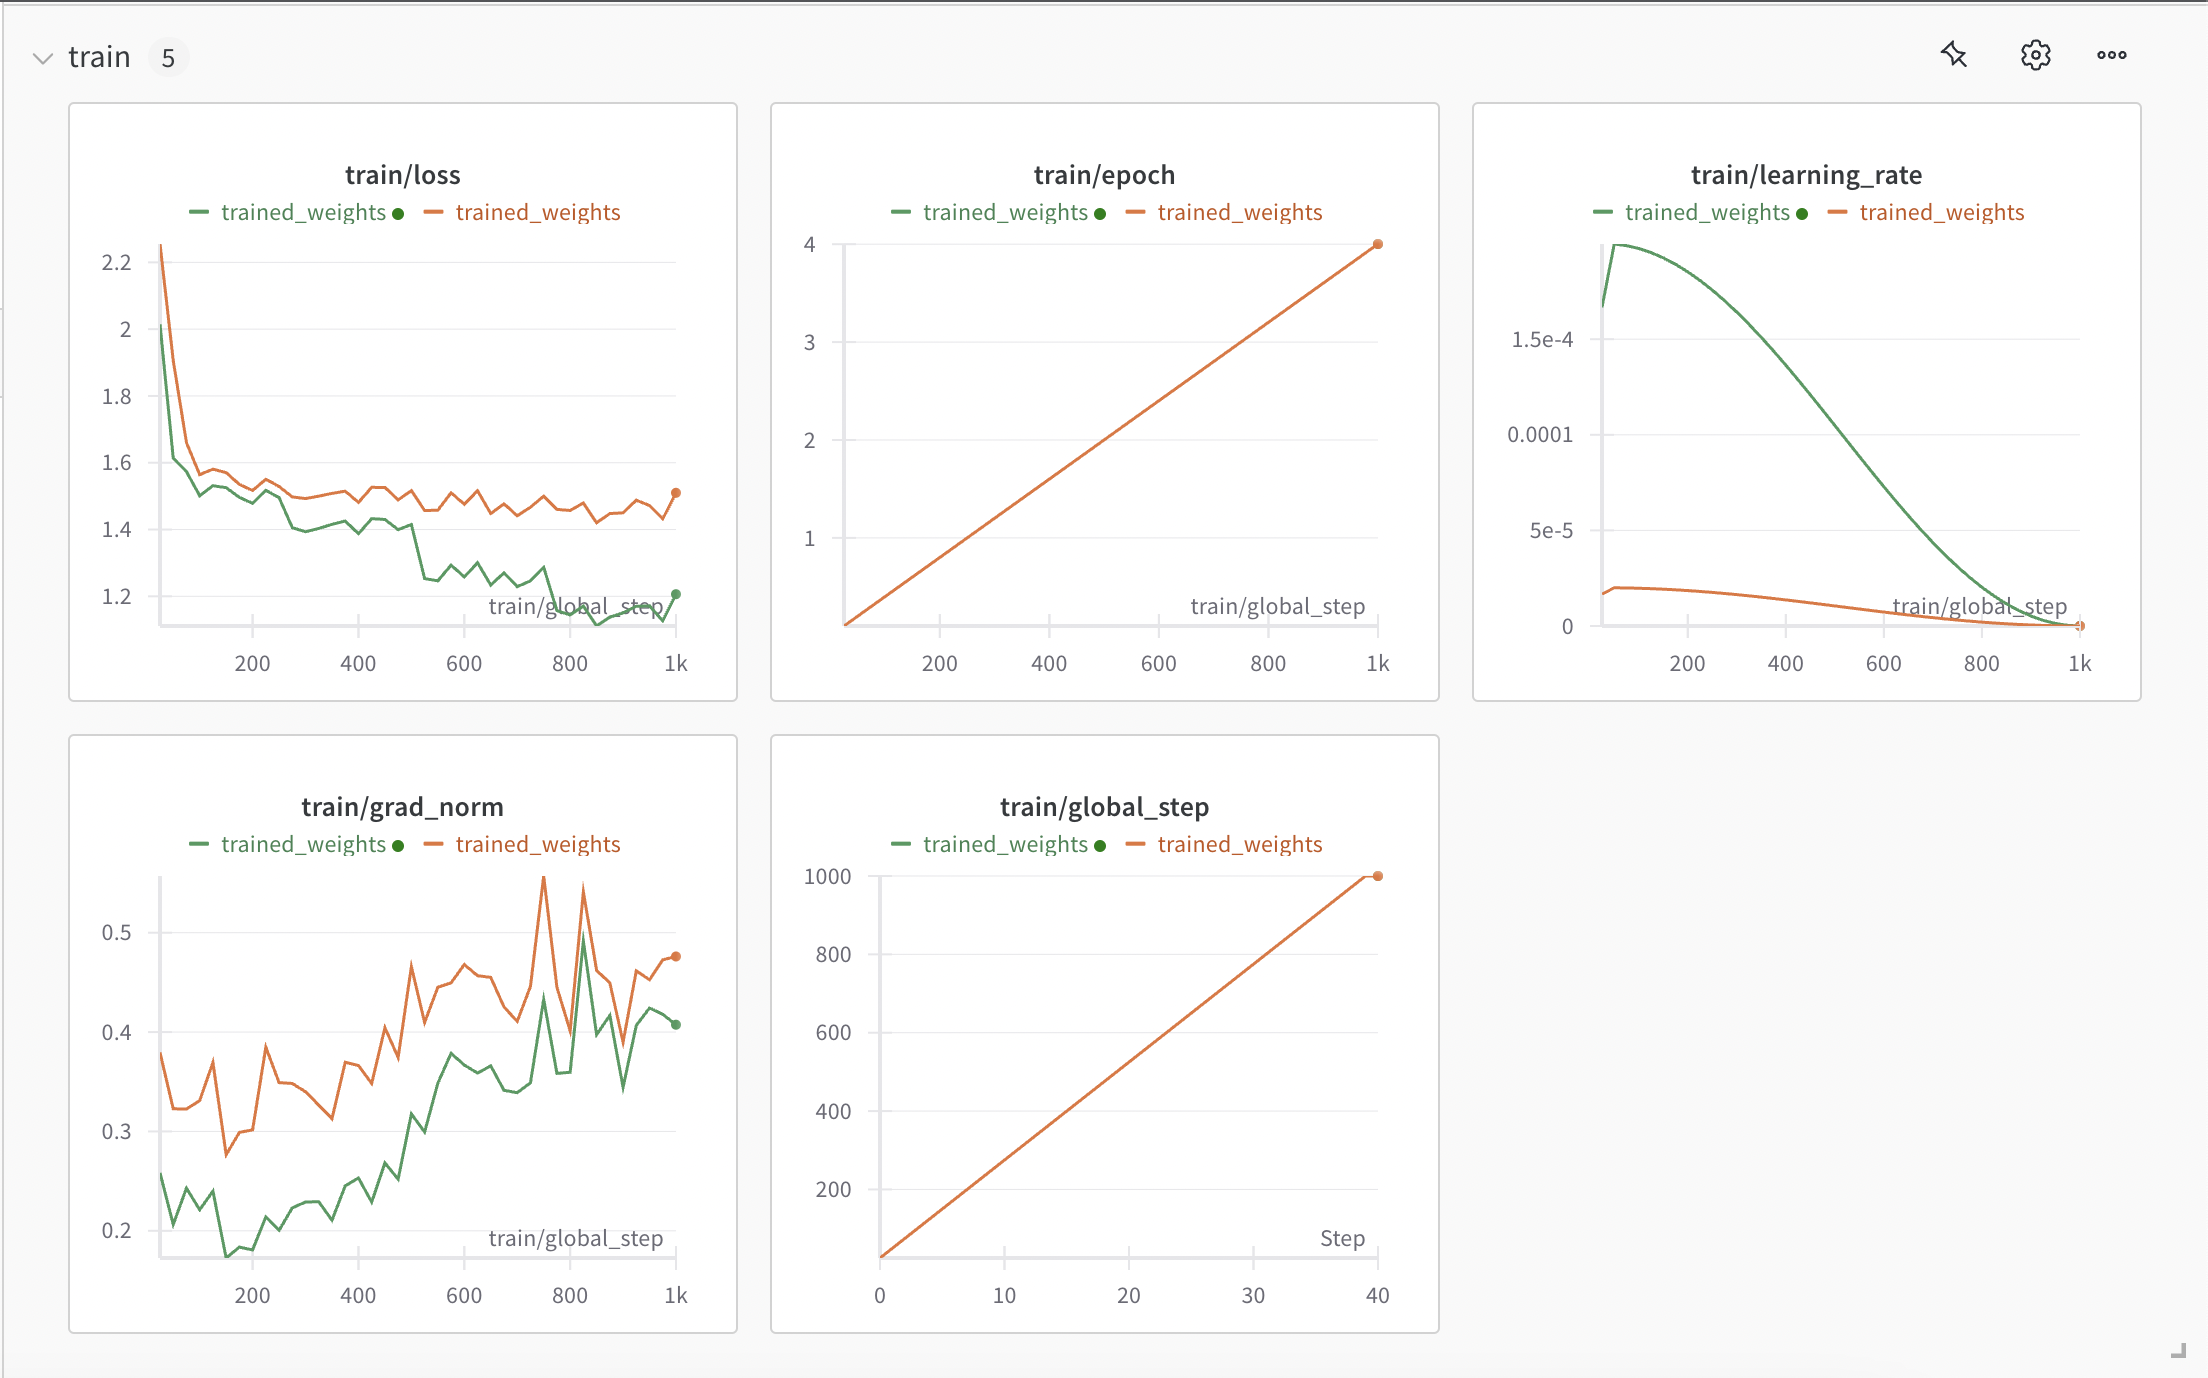